In [1]:
!pip install PyPortfolioOpt
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.objective_functions import transaction_cost, L2_reg
from pypfopt.risk_models import CovarianceShrinkage
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Read in the predictions**

In [2]:
lstm = pd.read_csv('/content/drive/My Drive/Portfolio Management/LSTM_Predictions.csv') 
lstm.index = lstm['Date'] 
lstm.drop(['Date'], axis=1, inplace=True)
lstm = np.exp(lstm) - 1

gru = pd.read_csv('/content/drive/My Drive/Portfolio Management/GRU_Predictions.csv') 
gru.index = gru['Date'] 
gru.drop(['Date'], axis=1, inplace=True)
gru = np.exp(gru) - 1

naive = pd.read_csv('/content/drive/My Drive/Portfolio Management/Naive_Predictions.csv') 
naive.index = naive['Date'] 
naive.drop(['Date'], axis=1, inplace=True)
naive = np.exp(naive) - 1

drift = pd.read_csv('/content/drive/My Drive/Portfolio Management/Drift_Predictions.csv') 
drift.index = drift['Date'] 
drift.drop(['Date'], axis=1, inplace=True)
drift = np.exp(drift) - 1

pct_weekly_returns = pd.read_csv('/content/drive/My Drive/Portfolio Management/Percentage_Weekly_Returns.csv')
pct_weekly_returns = pct_weekly_returns[1::5]
pct_weekly_returns.index = pct_weekly_returns['Date'] 
pct_weekly_returns.drop(['Date'], axis=1, inplace=True)

rfr = pd.read_csv('/content/drive/My Drive/Portfolio Management/RFR.csv')
rfr['Date'] = pd.to_datetime(rfr.Date)
rfr.index = rfr['Date'] 
rfr.drop(['Date', 'Rate',	'Value','Quarterly RFR'], axis=1, inplace=True)

**Calculating the annualised Risk Free Rate**

In [3]:
risk_free_rate = []
for i in lstm.index:
  risk_free_rate.append(rfr.iloc[rfr.index.get_loc(i,method='nearest')][0])

**Porfolio Management**

In [4]:
def portfolio_returns(weights, returns):
  '''
  Calculate Portfolio Returns for a single period
  @params:
    weights - Portfolio weights
    returns - Returns from the portfolio
  @returns:
    Portfolio Returns
  '''
  return np.dot(weights, returns)

def portfolio_risk(weights, cov_matrix):
  '''
  Calculate Portfolio Risk for a single period
  @params:
    weights - Portfolio weights
    cov_matrix - Estimated covariance matrix
  @returns:
    Portfolio Risk (standard deviation)
  '''
  return np.sqrt(weights.T @ cov_matrix @ weights)

def sharpe_ratio(returns, rfr):
  '''
  Calculate the Sharpe Ratio of the portfolio
  @params:
    returns - Returns from the portfolio
    rfr - Risk free rate
  @returns:
    Annualised Sharpe Ratio
  '''
  return (np.mean(returns) - np.mean(rfr)) / np.std(np.array(returns) - rfr)

def information_ratio(returns, benchmark):
  '''
  Calculates the information ratio 
  @params:
    returns - portfolio returns
    benchmark - returns on the benchmark portfolio
  @returns:
    Annualised Information ratio
  '''
  diff = np.array(returns) - np.array(benchmark)
  return np.mean(diff) / np.std(diff)

def evaluate_portfolios(lstm, gru, naive, drift, ewp, rfr, title, index):
  '''
  Calculates Portfolio Cumulative returns, Annualised Sharp ratio and Information Ratio
  @params:
    lstm - lstm portfolio returns
    gru - gru portfolio returns
    naive - naive portfolio returns
    drift - drift portfolio returns
    ewp - ewp portfolio returns
    rfr - risk free rate
    title - Cumulative returns plot title
  @returns:
    plots the Portfolio Cumulative returns and prints Annualised Sharp ratio and Information Ratio
  '''
  print('Annualised Sharpe Ratio:')
  print(f'LSTM = {sharpe_ratio(lstm, rfr) * np.sqrt(52)}')
  print(f'GRU = {sharpe_ratio(gru, rfr) * np.sqrt(52)}')
  print(f'Naive = {sharpe_ratio(naive, rfr) * np.sqrt(52)}')
  print(f'Drift = {sharpe_ratio(drift, rfr) * np.sqrt(52)}')
  print(f'EWP = {sharpe_ratio(ewp, rfr) * np.sqrt(52)}')

  print('\nAnnualised Information Ratio:')
  print(f'LSTM = {information_ratio(lstm, ewp) * np.sqrt(52)}')
  print(f'GRU = {information_ratio(gru, ewp) * np.sqrt(52)}')
  print(f'Naive = {information_ratio(naive, ewp) * np.sqrt(52)}')
  print(f'Drift = {information_ratio(drift, ewp) * np.sqrt(52)}')

  df = pd.DataFrame(index=index)
  df.index = pd.to_datetime(df.index)
  df['LSTM'] = np.cumprod(1 + np.array(lstm))
  df['GRU'] = np.cumprod(1 + np.array(gru))
  df['Naive'] = np.cumprod(1 + np.array(naive))
  df['Drift'] = np.cumprod(1 + np.array(drift))
  df['EWP'] = np.cumprod(1 + np.array(ewp))

  plt.figure(figsize=(16,8))
  plt.plot(df['LSTM'], label=f'LSTM Portfolio ({np.round((np.cumprod(1 + np.array(lstm)))[-1], 2)})')
  plt.plot(df['GRU'], label=f'GRU Portfolio ({np.round((np.cumprod(1 + np.array(gru)))[-1], 2)})')
  plt.plot(df['Naive'], label=f'Naive Portfolio ({np.round((np.cumprod(1 + np.array(naive)))[-1], 2)})')
  plt.plot(df['Drift'], label=f'Drift Portfolio ({np.round((np.cumprod(1 + np.array(drift)))[-1], 2)})')
  plt.plot(df['EWP'], label=f'Equally Weighted Portfolio ({np.round((np.cumprod(1 + np.array(ewp)))[-1], 2)})')
  plt.title(title)
  plt.ylabel('Cumulative Returns')
  plt.xlabel('Date')
  plt.legend(loc='best')
  plt.show()

  return

**Equally Weighted Portfolio (Benchmark Portfolio)**

In [5]:
def ewp(pred_df, pct_returns, verbose=False):
  '''
  Carry out portfolio management for the test period
  @params:
    pred_df - DataFrame with predictions for t + 5 stored on day t (used for indexing)
    pct_returns - DataFrame with true percentage returns
    verbose - Print each periods returns and risk
  @returns:
    port_returns - Portfolio returns for each period
    port_risk - Portfolio risk for each period
    port_net_returns - Portfolio net returns for each period
  '''
  port_returns = []
  port_net_returns = []
  port_risk = []
  previous_weights = np.zeros(len(pred_df.columns))
  for i in range(len(pred_df)):
    #Actual Returns
    true_returns = pct_returns.loc[pred_df.index[i]].values
    true_returns = true_returns.reshape((true_returns.shape[0],1))

    #Get Historical returns that have been seen to estimate the covariance matrix
    train_returns = pct_returns.loc[pct_returns.index < pred_df.index[i]].values   
 
    #Estimate covariance matrix
    cov = LedoitWolf().fit(train_returns[-52:])

    #Rebalance EWP to have equal weights
    weights = np.zeros(len(pred_df.columns)) + (1 / len(pred_df.columns))

    #Calculate Transaction Cost
    tc = 0.003 * np.sum(np.abs(weights - previous_weights))

    #Portfolio Drift (Change in weights over the week from the initially allocated weights)
    weights = weights * (1 + pct_returns.loc[pred_df.index[i]].values)
    weights = weights / np.sum(weights)

    #Evaluate Portfolio
    port_returns.append(portfolio_returns(weights, true_returns)[0])
    port_risk.append(portfolio_risk(weights, cov.covariance_))
    port_net_returns.append(((1 + port_returns[i]) * (1 - tc)) - 1)

    previous_weights = weights
    
    if verbose:
      print(f'Week {i+1}: {pred_df.index[i]}')
      print(f'Returns = {port_returns[i] * 100}%')
      print(f'Risk = {port_risk[i] * 100}%')
      print(f'Net Returns = {port_net_returns[i] * 100}%\n')
      
  return port_returns, port_risk, port_net_returns

ewp_returns, ewp_risk, ewp_net_returns = ewp(lstm, pct_weekly_returns, verbose=True)

Week 1: 2005-05-09
Returns = -0.611345835085387%
Risk = 1.6289806909441693%
Net Returns = -0.9095117975801315%

Week 2: 2005-05-16
Returns = 1.0272308515655333%
Risk = 1.6124278250544128%
Net Returns = 1.023391526057904%

Week 3: 2005-05-23
Returns = 0.34417950387919016%
Risk = 1.5969728179470666%
Net Returns = 0.3381369487380992%

Week 4: 2005-05-30
Returns = 0.5911771727905561%
Risk = 1.535474007337871%
Net Returns = 0.5854859513436006%

Week 5: 2005-06-06
Returns = 0.7126509957205343%
Risk = 1.52833320450913%
Net Returns = 0.7063003545873858%

Week 6: 2005-06-13
Returns = -0.30990973063213645%
Risk = 1.54210837033183%
Net Returns = -0.3153616062771647%

Week 7: 2005-06-20
Returns = -1.0403525005404983%
Risk = 1.5165186415252279%
Net Returns = -1.0486648453396086%

Week 8: 2005-06-27
Returns = 0.3562764714774739%
Risk = 1.5334097521436585%
Net Returns = 0.351053758097275%

Week 9: 2005-07-04
Returns = 2.8800997393398378%
Risk = 1.5312521094240923%
Net Returns = 2.876910406427058%

We

**Mean Variance Optimisation**

In [6]:
def portfolio_management(pred_df, pct_returns, ra, bounds=(0,0.25), weight_change_factor=0.015, gamma=0.01, classic=False, verbose=False):
  '''
  Carry out portfolio management for the test period
  @params:
    pred_df - DataFrame with predictions for t + 5 stored on day t
    pct_returns - DataFrame with true percentage returns
    ra - risk aversion factor > 0
    bounds - weight bounds (tuple)
    weight_change_factor - Transaction Costs factor in adjusted MVO
    gamma - Regularisation factor in adjusted MVO
    classic - Whether to use classic MVO or adjusted MVO
    verbose - Print each periods returns and risk
  @returns:
    port_returns - Portfolio returns for each period
    port_risk - Portfolio risk for each period
    port_net_returns - Portfolio net returns for each period
  '''
  port_returns = []
  port_net_returns = []
  port_risk = []
  previous_weights = np.zeros(len(pred_df.columns))
  for i in range(len(pred_df)):
    #Actual Returns
    true_returns = pct_returns.loc[pred_df.index[i]].values
    true_returns = true_returns.reshape((true_returns.shape[0],1))

    #Get forecasted returns
    expected_returns = pred_df.loc[pred_df.index[i]].values
    expected_returns = expected_returns.reshape((expected_returns.shape[0],1))

    #Get Historical returns that have been seen to estimate the covariance matrix
    train_returns = pct_returns.loc[pct_returns.index < pred_df.index[i]].values 
    train_returns = np.vstack([train_returns, pred_df.loc[pred_df.index[i]].values])
    
    #Estimate covariance matrix
    cov = LedoitWolf().fit(train_returns[-52:])

    #Mean Variance Optimisation - Rebalancing
    ef = EfficientFrontier(expected_returns, cov.covariance_, weight_bounds=bounds)
    ef.add_objective(L2_reg, gamma=gamma)
    if classic == False:
      ef.add_objective(transaction_cost, w_prev=previous_weights, k=weight_change_factor)      
    ef.max_quadratic_utility(risk_aversion=ra)
    cleaned = ef.clean_weights()
    ef.set_weights(cleaned)
    
    #Calculate Transaction Cost
    tc = 0.003 * np.sum(np.abs(ef.weights - previous_weights))

    #Portfolio Drift (Change in weights over the week from the initially allocated weights)
    ef.weights = ef.weights * (1 + pct_returns.loc[pred_df.index[i]].values)
    ef.weights = ef.weights / np.sum(ef.weights)

    #Evaluate Portfolio
    port_returns.append(portfolio_returns(ef.weights, true_returns)[0])
    port_risk.append(portfolio_risk(ef.weights, cov.covariance_))
    port_net_returns.append(((1 + port_returns[i]) * (1 - tc)) - 1)

    previous_weights = ef.weights

    if verbose:
      print(f'Week {i+1}: {pred_df.index[i]}')
      print(f'Returns = {port_returns[i] * 100}%')
      print(f'Risk = {port_risk[i] * 100}%')
      print(f'Net Returns = {port_net_returns[i] * 100}%\n')

  return port_returns, port_risk, port_net_returns

**Classical MVO**

In [7]:
lstm_returns, lstm_risk, lstm_net_returns = portfolio_management(lstm, pct_weekly_returns, 1, bounds=(0,1), weight_change_factor=0, classic=True, verbose=True)

Week 1: 2005-05-09
Returns = -1.5730801725205013%
Risk = 2.0960720140439473%
Net Returns = -1.8683609320029437%

Week 2: 2005-05-16
Returns = 0.003911772360216297%
Risk = 2.4234615123321226%
Net Returns = -0.45109445397985004%

Week 3: 2005-05-23
Returns = 0.19354752689750634%
Risk = 2.5198767988857287%
Net Returns = -0.24228538742521177%

Week 4: 2005-05-30
Returns = -2.777777777777779%
Risk = 3.2268992400571213%
Net Returns = -2.9486315042944855%

Week 5: 2005-06-06
Returns = 1.0714285714285676%
Risk = 3.2393880894910563%
Net Returns = 1.0714285714285676%

Week 6: 2005-06-13
Returns = -0.8174663743033972%
Risk = 2.475825403164942%
Net Returns = -1.4125615760575805%

Week 7: 2005-06-20
Returns = 0.3500899588306311%
Risk = 2.43360834045057%
Net Returns = 0.2811599004924892%

Week 8: 2005-06-27
Returns = 1.0572867842604226%
Risk = 2.1409812581508283%
Net Returns = 0.8222255140544865%

Week 9: 2005-07-04
Returns = 10.465116279069765%
Risk = 4.038415043156463%
Net Returns = 9.802325581395

In [8]:
gru_returns, gru_risk, gru_net_returns = portfolio_management(gru, pct_weekly_returns, 1, bounds=(0,1), weight_change_factor=0, classic=True, verbose=True)

Week 1: 2005-05-09
Returns = -1.6466006736423608%
Risk = 2.2930997509496875%
Net Returns = -1.9416638222234162%

Week 2: 2005-05-16
Returns = 2.295060690512135%
Risk = 2.2573433394453364%
Net Returns = 1.9990883455150543%

Week 3: 2005-05-23
Returns = 3.3960243820060523%
Risk = 2.1966504984214708%
Net Returns = 3.003828786081697%

Week 4: 2005-05-30
Returns = 0.5027372005751248%
Risk = 2.374821721906704%
Net Returns = 0.05654182757328652%

Week 5: 2005-06-06
Returns = -0.03295431732437855%
Risk = 2.2990120663393667%
Net Returns = -0.5731170207915803%

Week 6: 2005-06-13
Returns = 1.3156728121248826%
Risk = 2.4052516914843487%
Net Returns = 1.1240883572577909%

Week 7: 2005-06-20
Returns = 0.0%
Risk = 2.978383868162012%
Net Returns = -0.45592946934602807%

Week 8: 2005-06-27
Returns = 0.9323558727636367%
Risk = 2.2017211902431604%
Net Returns = 0.3267617375270593%

Week 9: 2005-07-04
Returns = 3.5841839409802736%
Risk = 2.258341243529545%
Net Returns = 3.202216551657555%

Week 10: 2005-

In [9]:
naive_returns, naive_risk, naive_net_returns = portfolio_management(naive, pct_weekly_returns, 1, bounds=(0,1), weight_change_factor=0, classic=True, verbose=True)

Week 1: 2005-05-09
Returns = -1.9920318725099584%
Risk = 3.312430872271948%
Net Returns = -2.286055776892426%

Week 2: 2005-05-16
Returns = 3.267982359368292%
Risk = 2.2876958931777187%
Net Returns = 2.648374465212089%

Week 3: 2005-05-23
Returns = -1.146245059288542%
Risk = 3.2531162442495187%
Net Returns = -1.719165336491002%

Week 4: 2005-05-30
Returns = -2.559999999999996%
Risk = 3.4833362736079994%
Net Returns = -3.1446399999999985%

Week 5: 2005-06-06
Returns = 5.555350671624131%
Risk = 3.717311419951684%
Net Returns = 4.9220185675943995%

Week 6: 2005-06-13
Returns = -10.658039326416423%
Risk = 2.7008135548261616%
Net Returns = -10.962039642321997%

Week 7: 2005-06-20
Returns = 0.13295854729484508%
Risk = 2.274356400525353%
Net Returns = -0.4678392039889179%

Week 8: 2005-06-27
Returns = 0.6768302996752742%
Risk = 1.615224070421636%
Net Returns = 0.3318510729704016%

Week 9: 2005-07-04
Returns = 1.0774382771675906%
Risk = 1.9699602786481376%
Net Returns = 0.5983276378300317%

We

In [10]:
drift_returns, drift_risk, drift_net_returns = portfolio_management(drift, pct_weekly_returns, 1, bounds=(0,1), weight_change_factor=0, classic=True, verbose=True)

Week 1: 2005-05-09
Returns = -1.9920318725099584%
Risk = 3.3422551315790625%
Net Returns = -2.286055776892426%

Week 2: 2005-05-16
Returns = 3.0969030969031137%
Risk = 2.3516331048986667%
Net Returns = 2.4783216783216933%

Week 3: 2005-05-23
Returns = -1.146245059288542%
Risk = 3.249592317312237%
Net Returns = -1.7393675889328164%

Week 4: 2005-05-30
Returns = -2.559999999999996%
Risk = 3.493855021977828%
Net Returns = -3.1446399999999985%

Week 5: 2005-06-06
Returns = 5.617977528089878%
Risk = 3.754829271332822%
Net Returns = 4.984269662921337%

Week 6: 2005-06-13
Returns = -8.769846130899921%
Risk = 2.7939983650513374%
Net Returns = -9.023825405462272%

Week 7: 2005-06-20
Returns = 0.5161500139118048%
Risk = 2.393081077984275%
Net Returns = -0.08694688617165713%

Week 8: 2005-06-27
Returns = 0.6745500986861791%
Risk = 1.6801470758610513%
Net Returns = 0.3646255096983797%

Week 9: 2005-07-04
Returns = 1.141995446339502%
Risk = 2.002424932545839%
Net Returns = 0.6672612580729931%

Week

Before Transaction Costs:
Annualised Sharpe Ratio:
LSTM = 0.7641022238069392
GRU = 0.6998021292210287
Naive = -0.9221381773331213
Drift = -0.8377359931592295
EWP = 0.4890736630216456

Annualised Information Ratio:
LSTM = 0.6484695178197295
GRU = 0.5445043137759296
Naive = -1.6409045321525764
Drift = -1.5211701096962762


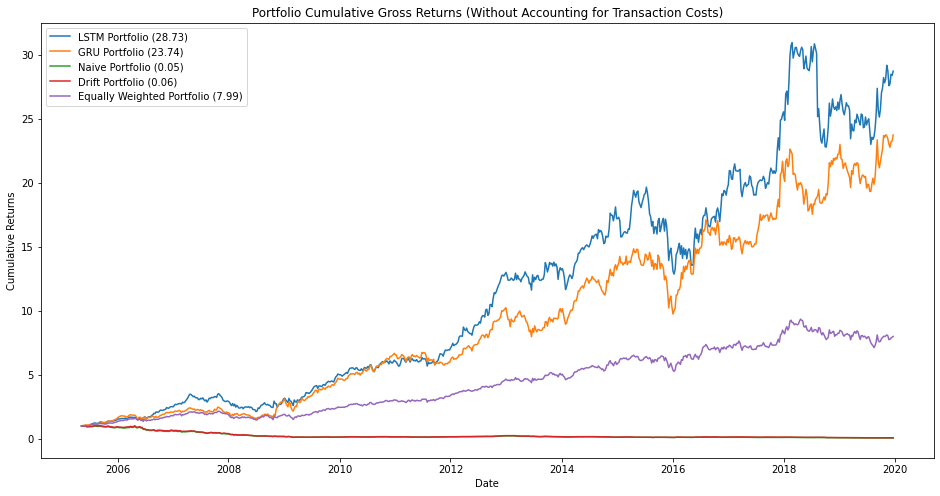

In [11]:
print('Before Transaction Costs:')
evaluate_portfolios(lstm_returns, gru_returns, naive_returns, drift_returns, ewp_returns, risk_free_rate, 'Portfolio Cumulative Gross Returns (Without Accounting for Transaction Costs)', lstm.index)

After Transaction Costs
Annualised Sharpe Ratio:
LSTM = -0.03751894073572309
GRU = -0.09833529640848615
Naive = -2.0150784988215076
Drift = -1.9299199191867307
EWP = 0.4697813279091208

Annualised Information Ratio:
LSTM = -0.5910100329344207
GRU = -0.6539151779806474
Naive = -3.0620066602547316
Drift = -2.9319438521816554


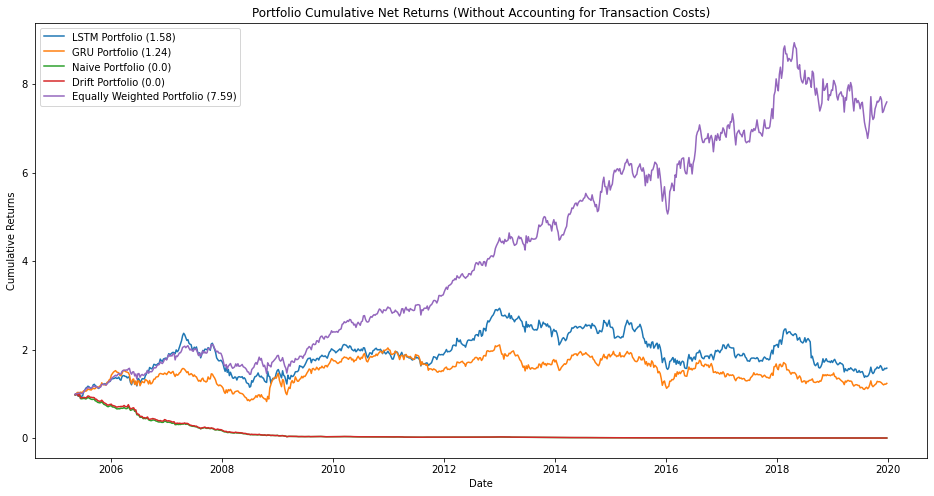

In [12]:
print('After Transaction Costs')
evaluate_portfolios(lstm_net_returns, gru_net_returns, naive_net_returns, drift_net_returns, ewp_net_returns, risk_free_rate, 'Portfolio Cumulative Net Returns (Without Accounting for Transaction Costs)', lstm.index)

**MVO Accounting for transaction costs**

In [13]:
lstm_returns, lstm_risk, lstm_net_returns = portfolio_management(lstm, pct_weekly_returns, 1, verbose=True)

Week 1: 2005-05-09
Returns = -1.5656161033294445%
Risk = 1.9006899220525806%
Net Returns = -1.860916301987936%

Week 2: 2005-05-16
Returns = 1.641448211920117%
Risk = 1.8329566255171907%
Net Returns = 1.5701787189509542%

Week 3: 2005-05-23
Returns = -0.8953468008043138%
Risk = 1.7632873826155397%
Net Returns = -0.8953528120706378%

Week 4: 2005-05-30
Returns = -0.7027771397842694%
Risk = 1.8510943690066908%
Net Returns = -0.7575933875513363%

Week 5: 2005-06-06
Returns = -0.32801674570657813%
Risk = 1.802756930422518%
Net Returns = -0.3759261405894665%

Week 6: 2005-06-13
Returns = 0.4013560348883508%
Risk = 1.7913421757354286%
Net Returns = 0.3991005027496275%

Week 7: 2005-06-20
Returns = -0.4313924355078135%
Risk = 1.7154966015911484%
Net Returns = -0.5804750696126071%

Week 8: 2005-06-27
Returns = 0.5354440772193338%
Risk = 1.7243786419774496%
Net Returns = 0.5341705422627241%

Week 9: 2005-07-04
Returns = 4.148027869811067%
Risk = 1.9020344916105731%
Net Returns = 3.9918245746513

In [14]:
gru_returns, gru_risk, gru_net_returns = portfolio_management(gru, pct_weekly_returns, 1, verbose=True)

Week 1: 2005-05-09
Returns = -0.9374236298307983%
Risk = 1.7214908144483034%
Net Returns = -1.2346083870640179%

Week 2: 2005-05-16
Returns = 1.038814397285806%
Risk = 1.7637903396815833%
Net Returns = 0.9033767212934807%

Week 3: 2005-05-23
Returns = 0.020690511718672155%
Risk = 1.6797583908428761%
Net Returns = 1.2318863262805735e-06%

Week 4: 2005-05-30
Returns = 1.4212967580490021%
Risk = 1.703428544782712%
Net Returns = 1.4012367956270477%

Week 5: 2005-06-06
Returns = -0.33906017459542975%
Risk = 1.6910333753462083%
Net Returns = -0.3712346984266368%

Week 6: 2005-06-13
Returns = 1.5645602871891582%
Risk = 1.684198974084511%
Net Returns = 1.5366941633160547%

Week 7: 2005-06-20
Returns = -0.8348056589018169%
Risk = 1.603422847010928%
Net Returns = -0.983597402631653%

Week 8: 2005-06-27
Returns = 0.7717194853089594%
Risk = 1.5798406166409034%
Net Returns = 0.7501614533969914%

Week 9: 2005-07-04
Returns = 2.3739691371276512%
Risk = 1.576721101783111%
Net Returns = 2.2660373234690

In [15]:
naive_returns, naive_risk, naive_net_returns = portfolio_management(naive, pct_weekly_returns, 1, verbose=True)

Week 1: 2005-05-09
Returns = -0.9562962293460285%
Risk = 2.5283944392393702%
Net Returns = -1.2534273406579977%

Week 2: 2005-05-16
Returns = 0.8833163700677344%
Risk = 1.8076676513833922%
Net Returns = 0.7053920507938738%

Week 3: 2005-05-23
Returns = -0.36078105782105174%
Risk = 1.7579899961497156%
Net Returns = -0.6315203922754753%

Week 4: 2005-05-30
Returns = 0.428205523969433%
Risk = 1.7154209696434175%
Net Returns = 0.12802920804497742%

Week 5: 2005-06-06
Returns = 1.9277213344263646%
Risk = 1.7918546583523594%
Net Returns = 1.6288555999071974%

Week 6: 2005-06-13
Returns = -4.406526750852041%
Risk = 1.8791921853506113%
Net Returns = -4.549954210043994%

Week 7: 2005-06-20
Returns = -2.101845552794584%
Risk = 1.756064711879291%
Net Returns = -2.4871865424019757%

Week 8: 2005-06-27
Returns = 0.5808314817404925%
Risk = 1.5120755674302553%
Net Returns = 0.2351572164668969%

Week 9: 2005-07-04
Returns = 1.7854773977458316%
Risk = 1.4895439307720673%
Net Returns = 1.778115432049487

In [16]:
drift_returns, drift_risk, drift_net_returns = portfolio_management(drift, pct_weekly_returns, 1, verbose=True)

Week 1: 2005-05-09
Returns = -0.964360557935777%
Risk = 2.5174334433103596%
Net Returns = -1.2614645051927775%

Week 2: 2005-05-16
Returns = 0.5705986918010911%
Risk = 1.8449900703402127%
Net Returns = 0.41972720961882537%

Week 3: 2005-05-23
Returns = -0.3616269184311015%
Risk = 1.7548019648530608%
Net Returns = -0.6605091570126898%

Week 4: 2005-05-30
Returns = 0.4152063048390763%
Risk = 1.7203530034149543%
Net Returns = 0.11506023243357255%

Week 5: 2005-06-06
Returns = 1.8705263937754069%
Risk = 1.8004748625134233%
Net Returns = 1.5495272715823072%

Week 6: 2005-06-13
Returns = -4.350504935181753%
Risk = 1.860716244369607%
Net Returns = -4.507018565906606%

Week 7: 2005-06-20
Returns = -2.3634389348957896%
Risk = 1.799022508709211%
Net Returns = -2.748472692514592%

Week 8: 2005-06-27
Returns = 0.8181830094699546%
Risk = 1.5611872072223734%
Net Returns = 0.43833381273095107%

Week 9: 2005-07-04
Returns = 2.027901942995205%
Risk = 1.542773584732216%
Net Returns = 2.022389063001584%


Before Transaction Costs:
Annualised Sharpe Ratio:
LSTM = 0.6670155911408503
GRU = 0.6518317956815197
Naive = -0.6373903033885759
Drift = -0.6442279580305894
EWP = 0.4890736630216456

Annualised Information Ratio:
LSTM = 0.6063587694193481
GRU = 0.563149144010588
Naive = -2.3919851752201633
Drift = -2.372683223254215


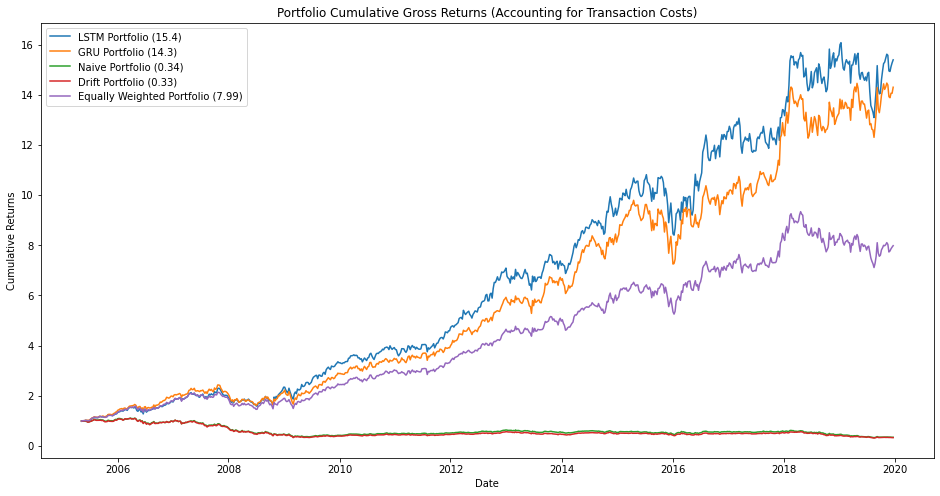

In [17]:
print('Before Transaction Costs:')
evaluate_portfolios(lstm_returns, gru_returns, naive_returns, drift_returns, ewp_returns, risk_free_rate, 'Portfolio Cumulative Gross Returns (Accounting for Transaction Costs)', lstm.index)

After Transaction Costs
Annualised Sharpe Ratio:
LSTM = 0.5280637261709571
GRU = 0.5160701571876252
Naive = -1.3855033240612045
Drift = -1.4391280288632906
EWP = 0.4697813279091208

Annualised Information Ratio:
LSTM = 0.3024884538314398
GRU = 0.25859637112065986
Naive = -3.95774030927007
Drift = -4.038149069389251


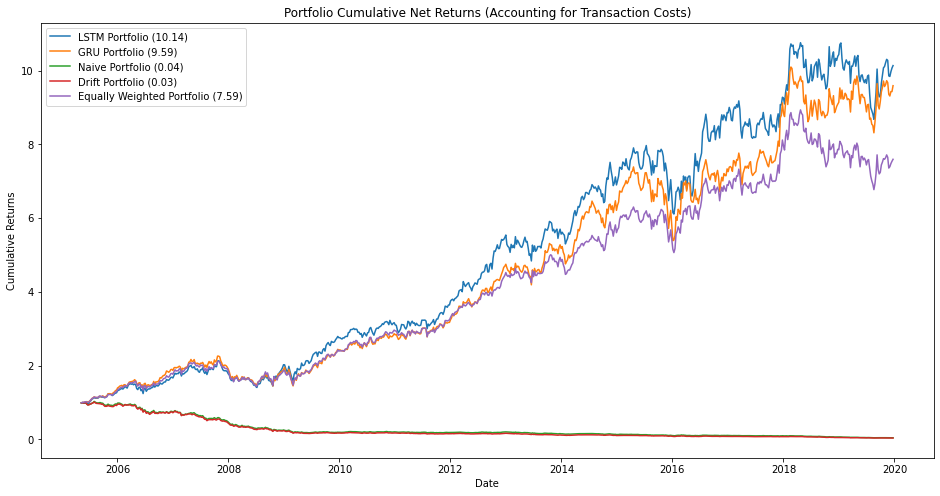

In [18]:
print('After Transaction Costs')
evaluate_portfolios(lstm_net_returns, gru_net_returns, naive_net_returns, drift_net_returns, ewp_net_returns, risk_free_rate, 'Portfolio Cumulative Net Returns (Accounting for Transaction Costs)', lstm.index)